# Stick Barrette

> A hair clip made up of two parts

| Main (top/outer) part | Stick (bottom/inner) part |
| --- | --- |
| <a title="Auckland Museum, CC BY 4.0 &lt;https://creativecommons.org/licenses/by/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Hair_slide_(AM_1993.1-3).jpg"><img width="256" alt="Hair slide (AM 1993.1-3)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hair_slide_%28AM_1993.1-3%29.jpg/512px-Hair_slide_%28AM_1993.1-3%29.jpg?20191031040432"></a> | <a title="Auckland Museum, CC BY 4.0 &lt;https://creativecommons.org/licenses/by/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Hair_slide_(AM_1993.1-4).jpg"><img width="256" alt="Hair slide (AM 1993.1-4)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Hair_slide_%28AM_1993.1-4%29.jpg/512px-Hair_slide_%28AM_1993.1-4%29.jpg?20191031040453"></a> |

Lets design this part. As opposed to other hair clips, there is no need for complex spring mechanism,
and the whole thing can be 3d printed without any supports.

In [ ]:
#| default_exp scad.helpers.arc

In [ ]:
#| export
from cadlab.scad import *
from solid2 import *
from math import pi, cos, sin
from fastcore.all import *
from cmath import exp
import numpy as np

In [ ]:
set_global_fn(100)

Length of the outer part.

In [ ]:
outer_length = 120

Now we need the radius of circumference. [This](https://en.wikipedia.org/wiki/Occipital_bone) is the part of the human skull we are interested in. The radius of circumference varies from person to person, but is about 9 cm according to Llama 3.3 70B, and that sounds about right, so I am gonna trust it for now.

In [ ]:
outer_radius = 90

Note that we could make an arc by subtracting a section from a circle, but this won't work for angles larger than 180 degrees. So let's just use a polygon.

In [ ]:
#| export
def arc_2d(r, start_angle, end_angle, thickness, step=0.5):
    angles = np.arange(np.deg2rad(start_angle), np.deg2rad(end_angle)+np.deg2rad(step), np.deg2rad(step))
    unit_points = np.stack([np.cos(angles), np.sin(angles)],axis=1)
    points = np.concat([r*unit_points, (r-thickness)*np.flip(unit_points, axis=0)])
    
    return polygon(points)

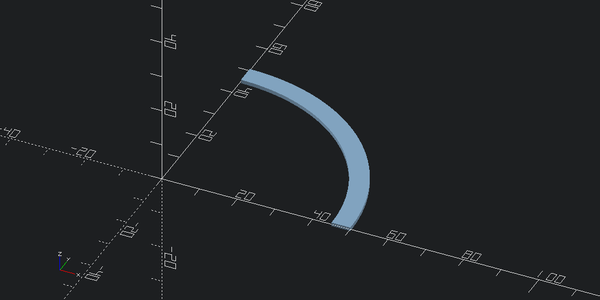

In [ ]:
r = 50
thickness = 5

start_angle = 0
end_angle = 90
arc_2d(r, start_angle, end_angle, thickness)

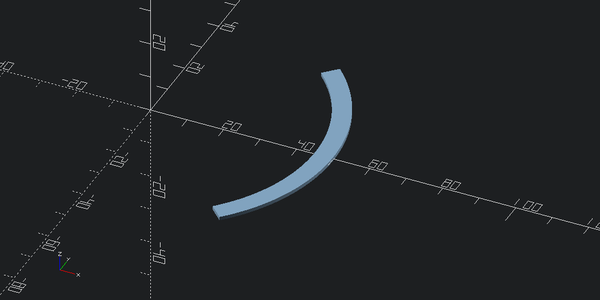

In [ ]:
arc_2d(r, -45, 45, thickness)

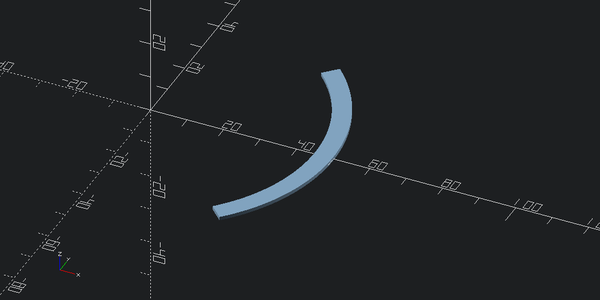

In [ ]:
arc_2d(r, -45, 45, thickness)

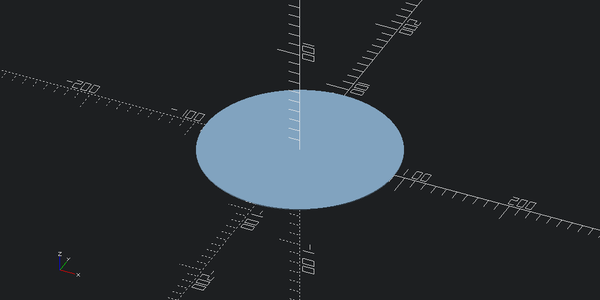

In [ ]:
circle(r=outer_radius)

Now, we don't want the whole circle, we just want an arc.

We can make an arc by subtracting a section from a circle.

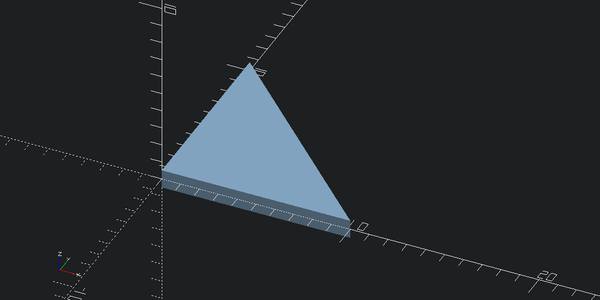

In [ ]:
r = 10
polygon([[0,0], [r,0], [0,r]])

Now, we would like to specify arc length. So, we need arc angle from arc length.

$$
\text{arc\_length} = \text{arc\_angle} \cdot r
$$

where `arc_angle` is in radians.

In [ ]:
#| export
def arc_angle(arc_length, r, deg=False): return arc_length / r * (180/pi if deg else 1)

In [ ]:
arc_angle(outer_length, outer_radius, True)

76.39437268410975

In [ ]:
arc_angle(outer_length, outer_radius, False)

1.3333333333333333

In [ ]:
arc_angle(outer_length, outer_radius, True)

In [ ]:
r = outer_radius*2
half_angle = arc_angle(outer_length, outer_radius, False)/2

In [ ]:
p1 = r*exp(half_angle*1j)
p2 = r*exp(-half_angle*1j)

print(p1, p2)

(141.45970693985063+111.30656455255266j) (141.45970693985063-111.30656455255266j)


In [ ]:
#| export
def to_tuple(c:complex):
    return (c.real, c.imag)

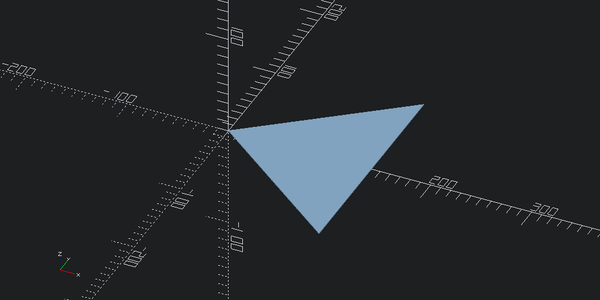

In [ ]:
polygon([[0,0], to_tuple(p1), to_tuple(p2)])

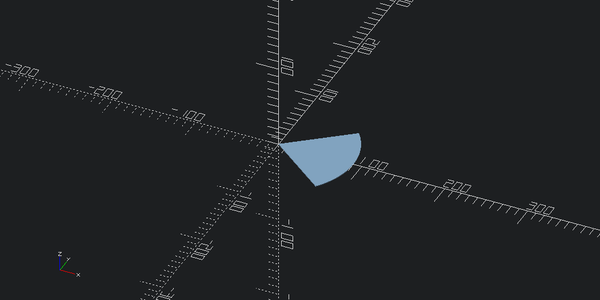

In [ ]:
circle(r=outer_radius) * polygon([[0,0], to_tuple(p1), to_tuple(p2)])

In [ ]:
#| export
def conic_arc(r, l):
    r2 = r*2
    half_angle = arc_angle(l, r2, False)/2
    return circle(r=r) * polygon([[0,0], to_tuple(p1), to_tuple(p2)])

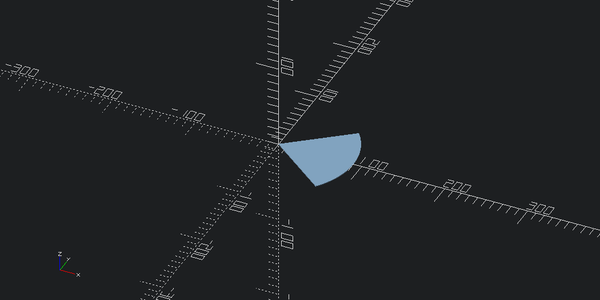

In [ ]:
conic_arc(outer_radius, outer_length)

Let's quickly test that the angle is correct. The expression below should give a cirlce.

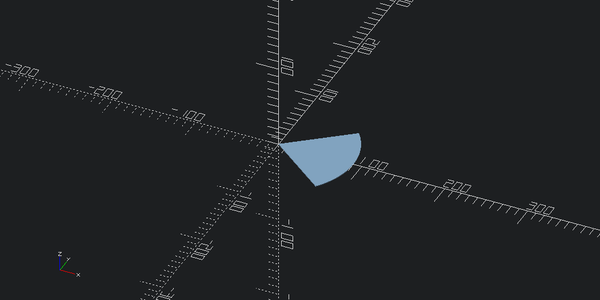

In [ ]:
conic_arc(outer_radius, outer_radius*2*pi)

Now, to make a hollow arc, we just subtract inner part.

In [ ]:
#| export
def hollow_arc(r, l, thickness): return conic_arc(r, l) - circle(r-thickness)

Btw, what thickness we want for our barette? 5mm would probably be ok.

In [ ]:
outer_thickness = 5

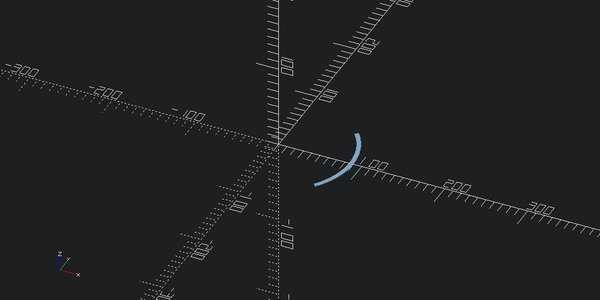

In [ ]:
hollow_arc(outer_radius, outer_length, outer_thickness)

In [ ]:
outer_height = 40

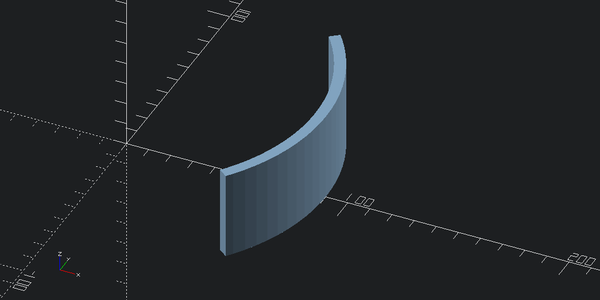

In [ ]:
arc = hollow_arc(outer_radius, outer_length, outer_thickness)
outer_part = linear_extrude(outer_height)(arc)
outer_part

Cool, let's make it into a reusable function!

In [ ]:
#| export
def arc_3d(r, l, thickness, height): return linear_extrude(height)(hollow_arc(r, l, thickness))

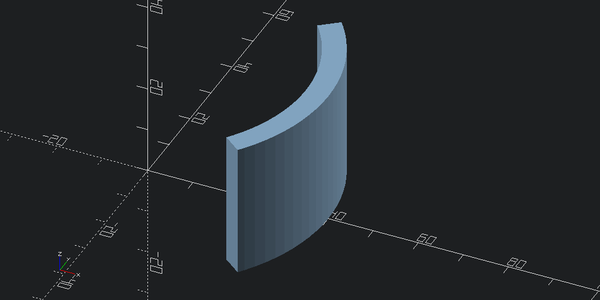

In [ ]:
arc_3d(40,5,5,30)